# 🗳️ Ensemble Voting Model: Combining All 6 Models

**Goal**: Create an ensemble model that combines predictions from all 6 regression models using a voting/averaging strategy

**Models Combined:**
1. Random Forest (RF)
2. Random Forest + PCA (RF_PCA)
3. XGBoost (XGB)
4. XGBoost + PCA (XGB_PCA)
5. Neural Network (NN)
6. Neural Network + PCA (NN_PCA)

**Ensemble Strategies:**
- **Simple Average**: Equal weight to all models
- **Weighted Average**: Weight by R² performance
- **Best-N Average**: Use only top N performers
- **Median**: Robust to outliers

**Hypothesis**: Ensemble should outperform individual models by:
- Reducing variance
- Capturing different patterns
- Being more robust to errors

---


In [14]:
# Import libraries
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# TensorFlow for Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


✅ Libraries imported successfully!
TensorFlow version: 2.20.0


## 📂 Step 1: Load and Prepare Data

We'll use a consistent 80/20 split for all models to ensure fair comparison.


In [15]:
# Load processed RDKit features
df_rdkit = pd.read_csv('processed_DAT_rdkit_features.csv')

# Prepare features and target
feature_cols = [col for col in df_rdkit.columns if col not in ['ChEMBL_ID', 'pKi']]
X = df_rdkit[feature_cols].values
y = df_rdkit['pKi'].values

print("="*60)
print("📂 DATA LOADED")
print("="*60)
print(f"Total compounds: {len(df_rdkit)}")
print(f"Features: {len(feature_cols)} RDKit descriptors")
print(f"Target range: {y.min():.2f} - {y.max():.2f} pKi")
print("="*60)

# 80/20 Train-Test Split (consistent across all models)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\n📊 Train/Test Split (80/20):")
print(f"   Training: {len(X_train)} compounds ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test: {len(X_test)} compounds ({len(X_test)/len(X)*100:.1f}%)")

# Standardize features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA transformation
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\n🔄 PCA Applied:")
print(f"   Components: {X_train_pca.shape[1]} (explaining {pca.explained_variance_ratio_.sum()*100:.2f}% variance)")
print("="*60)


📂 DATA LOADED
Total compounds: 541
Features: 17 RDKit descriptors
Target range: 3.41 - 10.40 pKi

📊 Train/Test Split (80/20):
   Training: 432 compounds (79.9%)
   Test: 109 compounds (20.1%)

🔄 PCA Applied:
   Components: 7 (explaining 95.00% variance)


## 🎯 Step 2: Train All 6 Individual Models

Train each model with their optimal hyperparameters (from previous notebooks).


## 🔄 Step 2A: Load Saved Models (if available)

This will load pre-trained models from `saved_models/` to avoid retraining. If files are missing, we'll train and save them.


In [16]:
# Attempt to load saved models
models_loaded = False
saved_dir = 'saved_models'

if os.path.isdir(saved_dir):
    try:
        print("📂 Loading models from saved_models/ ...")
        # Random Forest
        rf_model = joblib.load(os.path.join(saved_dir, 'rf_model.pkl'))
        rf_scaler = joblib.load(os.path.join(saved_dir, 'rf_scaler.pkl'))
        # RF + PCA
        rf_pca_model = joblib.load(os.path.join(saved_dir, 'rf_pca_model.pkl'))
        rf_pca_scaler = joblib.load(os.path.join(saved_dir, 'rf_pca_scaler.pkl'))
        rf_pca_pca = joblib.load(os.path.join(saved_dir, 'rf_pca_transformer.pkl'))
        # XGBoost
        xgb_model = joblib.load(os.path.join(saved_dir, 'xgb_model.pkl'))
        xgb_scaler = joblib.load(os.path.join(saved_dir, 'xgb_scaler.pkl'))
        # XGB + PCA
        xgb_pca_model = joblib.load(os.path.join(saved_dir, 'xgb_pca_model.pkl'))
        xgb_pca_scaler = joblib.load(os.path.join(saved_dir, 'xgb_pca_scaler.pkl'))
        xgb_pca_pca = joblib.load(os.path.join(saved_dir, 'xgb_pca_transformer.pkl'))
        # Neural Networks (load with compile=False to avoid deserialization issues)
        nn_model = keras.models.load_model(os.path.join(saved_dir, 'nn_model.h5'), compile=False)
        nn_scaler = joblib.load(os.path.join(saved_dir, 'nn_scaler.pkl'))
        nn_pca_model = keras.models.load_model(os.path.join(saved_dir, 'nn_pca_model.h5'), compile=False)
        nn_pca_scaler = joblib.load(os.path.join(saved_dir, 'nn_pca_scaler.pkl'))
        nn_pca_pca = joblib.load(os.path.join(saved_dir, 'nn_pca_transformer.pkl'))
        
        # Recompile the models for inference (without problematic custom metrics)
        nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        nn_pca_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        models_loaded = True
        print("✅ All models loaded from disk. Skipping training.")
    except FileNotFoundError as e:
        print(f"⚠️  Missing model file: {e}")
        print("   Will train models and save them.")
else:
    print("ℹ️  No saved_models directory found. Models will be trained and saved.")


📂 Loading models from saved_models/ ...
✅ All models loaded from disk. Skipping training.


In [17]:
if models_loaded:
    print("✅ Models already loaded. Skipping training.")
else:
    print("🚀 Training all 6 models...")
    print("="*60)

    os.makedirs(saved_dir, exist_ok=True)

    # Model 1: Random Forest (best parameters from RF notebook)
    print("\n1️⃣ Training Random Forest...")
    rf_model = RandomForestRegressor(
        n_estimators=363,
        max_depth=None,
        max_features='log2',
        min_samples_leaf=2,
        min_samples_split=2,
        bootstrap=False,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train_scaled, y_train)
    rf_scaler = scaler  # keep reference
    joblib.dump(rf_model, os.path.join(saved_dir, 'rf_model.pkl'))
    joblib.dump(rf_scaler, os.path.join(saved_dir, 'rf_scaler.pkl'))
    print("   ✅ Random Forest trained & saved")

    # Model 2: Random Forest + PCA
    print("\n2️⃣ Training Random Forest + PCA...")
    rf_pca_model = RandomForestRegressor(
        n_estimators=359,
        max_depth=25,
        max_features='log2',
        min_samples_leaf=2,
        min_samples_split=3,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    rf_pca_model.fit(X_train_pca, y_train)
    rf_pca_scaler = scaler
    rf_pca_pca = pca
    joblib.dump(rf_pca_model, os.path.join(saved_dir, 'rf_pca_model.pkl'))
    joblib.dump(rf_pca_scaler, os.path.join(saved_dir, 'rf_pca_scaler.pkl'))
    joblib.dump(rf_pca_pca, os.path.join(saved_dir, 'rf_pca_transformer.pkl'))
    print("   ✅ Random Forest + PCA trained & saved")

    # Model 3: XGBoost (best parameters from XGB notebook)
    print("\n3️⃣ Training XGBoost...")
    xgb_model = XGBRegressor(
        n_estimators=415,
        learning_rate=0.0295,
        max_depth=6,
        min_child_weight=1,
        subsample=0.606,
        colsample_bytree=0.843,
        gamma=0.085,
        reg_alpha=0.563,
        reg_lambda=0.771,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train_scaled, y_train)
    xgb_scaler = scaler
    joblib.dump(xgb_model, os.path.join(saved_dir, 'xgb_model.pkl'))
    joblib.dump(xgb_scaler, os.path.join(saved_dir, 'xgb_scaler.pkl'))
    print("   ✅ XGBoost trained & saved")

    # Model 4: XGBoost + PCA
    print("\n4️⃣ Training XGBoost + PCA...")
    xgb_pca_model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    xgb_pca_model.fit(X_train_pca, y_train)
    xgb_pca_scaler = scaler
    xgb_pca_pca = pca
    joblib.dump(xgb_pca_model, os.path.join(saved_dir, 'xgb_pca_model.pkl'))
    joblib.dump(xgb_pca_scaler, os.path.join(saved_dir, 'xgb_pca_scaler.pkl'))
    joblib.dump(xgb_pca_pca, os.path.join(saved_dir, 'xgb_pca_transformer.pkl'))
    print("   ✅ XGBoost + PCA trained & saved")

    # Model 5: Neural Network
    print("\n5️⃣ Training Neural Network...")
    nn_model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    nn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.15)
    nn_scaler = scaler
    nn_model.save(os.path.join(saved_dir, 'nn_model.h5'))
    joblib.dump(nn_scaler, os.path.join(saved_dir, 'nn_scaler.pkl'))
    print("   ✅ Neural Network trained & saved")

    # Model 6: Neural Network + PCA
    print("\n6️⃣ Training Neural Network + PCA...")
    nn_pca_model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    nn_pca_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    nn_pca_model.fit(X_train_pca, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.15)
    nn_pca_scaler = scaler
    nn_pca_pca = pca
    nn_pca_model.save(os.path.join(saved_dir, 'nn_pca_model.h5'))
    joblib.dump(nn_pca_scaler, os.path.join(saved_dir, 'nn_pca_scaler.pkl'))
    joblib.dump(nn_pca_pca, os.path.join(saved_dir, 'nn_pca_transformer.pkl'))
    print("   ✅ Neural Network + PCA trained & saved")

    print("\n" + "="*60)
    print("✅ All 6 models trained and saved successfully!")
    print("="*60)

✅ Models already loaded. Skipping training.


## Get Individual Predictions


In [18]:
# Get predictions from all models on test set
print("📊 Generating predictions from all models...")
print("="*60)

# === NON-PCA MODELS: Simple scaling ===
X_test_rf_scaled = rf_scaler.transform(X_test)
X_test_xgb_scaled = xgb_scaler.transform(X_test)
X_test_nn_scaled = nn_scaler.transform(X_test)

# === PCA MODELS: Need to recreate the full pipeline ===
# For PCA models, the saved PCA transformer was fitted on SCALED features
# So we need to: (1) scale raw features, (2) apply PCA, (3) scale PCA components (NN only)

# RF + PCA: The rf_pca_scaler is fitted on raw features, then PCA is applied
X_test_rf_pca_scaled = rf_pca_scaler.transform(X_test)  # Scale raw features
X_test_rf_pca_feat = rf_pca_pca.transform(X_test_rf_pca_scaled)  # Apply PCA

# XGB + PCA: Same as RF+PCA
X_test_xgb_pca_scaled = xgb_pca_scaler.transform(X_test)  # Scale raw features
X_test_xgb_pca_feat = xgb_pca_pca.transform(X_test_xgb_pca_scaled)  # Apply PCA

# NN + PCA: The PCA was fitted on scaled features, but we need to recreate the first scaler
# The issue: nn_pca_pca expects scaled input, but the scaler for that wasn't saved!
# Solution: Use the scaler from Cell 3 that was already created
X_test_scaled_for_pca = scaler.transform(X_test)  # Use the scaler from Cell 3
X_test_nn_pca_components = nn_pca_pca.transform(X_test_scaled_for_pca)  # Apply PCA (17→8)
X_test_nn_pca_scaled = nn_pca_scaler.transform(X_test_nn_pca_components)  # Scale PCA components (8→8)

# Get predictions
pred_rf = rf_model.predict(X_test_rf_scaled)
pred_rf_pca = rf_pca_model.predict(X_test_rf_pca_feat)
pred_xgb = xgb_model.predict(X_test_xgb_scaled)
pred_xgb_pca = xgb_pca_model.predict(X_test_xgb_pca_feat)
pred_nn = nn_model.predict(X_test_nn_scaled, verbose=0).flatten()
pred_nn_pca = nn_pca_model.predict(X_test_nn_pca_scaled, verbose=0).flatten()

# ... rest of the code ...
# Evaluate individual models
models_info = {
    'Random Forest': pred_rf,
    'RF + PCA': pred_rf_pca,
    'XGBoost': pred_xgb,
    'XGB + PCA': pred_xgb_pca,
    'Neural Network': pred_nn,
    'NN + PCA': pred_nn_pca
}

individual_results = []
print("\n📈 Individual Model Performance on Test Set:")
print("-"*60)
for model_name, predictions in models_info.items():
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    individual_results.append({
        'Model': model_name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae
    })
    print(f"{model_name:20s} → R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print("="*60)

# Store predictions in DataFrame for ensemble
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'RF': pred_rf,
    'RF_PCA': pred_rf_pca,
    'XGB': pred_xgb,
    'XGB_PCA': pred_xgb_pca,
    'NN': pred_nn,
    'NN_PCA': pred_nn_pca
})

print(f"\n✅ All predictions generated!")
print(f"   Test set size: {len(y_test)} compounds")


📊 Generating predictions from all models...

📈 Individual Model Performance on Test Set:
------------------------------------------------------------
Random Forest        → R²: 0.9232, RMSE: 0.3156, MAE: 0.2215
RF + PCA             → R²: 0.8929, RMSE: 0.3727, MAE: 0.2823
XGBoost              → R²: 0.5811, RMSE: 0.7369, MAE: 0.5250
XGB + PCA            → R²: 0.4623, RMSE: 0.8348, MAE: 0.6340
Neural Network       → R²: 0.5011, RMSE: 0.8041, MAE: 0.5732
NN + PCA             → R²: 0.5228, RMSE: 0.7865, MAE: 0.5859

✅ All predictions generated!
   Test set size: 109 compounds


## Ensemble Voting Strategies


In [19]:
print("🗳️ Creating Ensemble Predictions...")
print("="*70)

# Get R² scores for weighting
r2_scores = np.array([res['R²'] for res in individual_results])
model_names = [res['Model'] for res in individual_results]

# Strategy 1: Simple Average (Equal Weight)
ensemble_simple = predictions_df[['RF', 'RF_PCA', 'XGB', 'XGB_PCA', 'NN', 'NN_PCA']].mean(axis=1).values

# Strategy 2: Weighted Average (by R² score)
# Normalize R² scores to sum to 1
weights = r2_scores / r2_scores.sum()
ensemble_weighted = np.zeros(len(y_test))
for i, model in enumerate(['RF', 'RF_PCA', 'XGB', 'XGB_PCA', 'NN', 'NN_PCA']):
    ensemble_weighted += predictions_df[model].values * weights[i]

# Strategy 3: Top-3 Average (Best 3 models only)
top_3_indices = np.argsort(r2_scores)[-3:]
top_3_models = [list(predictions_df.columns)[i+1] for i in top_3_indices]  # +1 to skip 'Actual'
ensemble_top3 = predictions_df[top_3_models].mean(axis=1).values

# Strategy 4: Median (Robust to outliers)
ensemble_median = predictions_df[['RF', 'RF_PCA', 'XGB', 'XGB_PCA', 'NN', 'NN_PCA']].median(axis=1).values

# Strategy 5: Best Model Only (for comparison)
best_model_idx = np.argmax(r2_scores)
best_model_name = list(predictions_df.columns)[best_model_idx + 1]
ensemble_best = predictions_df[best_model_name].values

# Evaluate all ensemble strategies
ensemble_strategies = {
    'Simple Average (All 6)': ensemble_simple,
    'Weighted Average (by R²)': ensemble_weighted,
    'Top-3 Average': ensemble_top3,
    'Median (Robust)': ensemble_median,
    f'Best Model Only ({best_model_name})': ensemble_best
}

ensemble_results = []
print("\n🏆 ENSEMBLE PERFORMANCE COMPARISON:")
print("-"*70)
for strategy_name, predictions in ensemble_strategies.items():
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    ensemble_results.append({
        'Strategy': strategy_name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae
    })
    print(f"{strategy_name:30s} → R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print("="*70)

# Find best ensemble
best_ensemble_idx = np.argmax([res['R²'] for res in ensemble_results])
best_ensemble = ensemble_results[best_ensemble_idx]
print(f"\n🥇 BEST ENSEMBLE STRATEGY: {best_ensemble['Strategy']}")
print(f"   R² Score: {best_ensemble['R²']:.4f}")
print(f"   RMSE: {best_ensemble['RMSE']:.4f}")
print(f"   MAE: {best_ensemble['MAE']:.4f}")

# Compare to best individual model
best_individual = individual_results[np.argmax([res['R²'] for res in individual_results])]
improvement = ((best_ensemble['R²'] - best_individual['R²']) / best_individual['R²']) * 100

print(f"\n📊 IMPROVEMENT OVER BEST INDIVIDUAL MODEL:")
print(f"   Best Individual: {best_individual['Model']} (R² = {best_individual['R²']:.4f})")
print(f"   Best Ensemble: {best_ensemble['Strategy']}")
print(f"   Improvement: {improvement:+.2f}%")
print("="*70)


🗳️ Creating Ensemble Predictions...

🏆 ENSEMBLE PERFORMANCE COMPARISON:
----------------------------------------------------------------------
Simple Average (All 6)         → R²: 0.7388, RMSE: 0.5819, MAE: 0.4308
Weighted Average (by R²)       → R²: 0.7858, RMSE: 0.5270, MAE: 0.3903
Top-3 Average                  → R²: 0.8368, RMSE: 0.4600, MAE: 0.3338
Median (Robust)                → R²: 0.7562, RMSE: 0.5621, MAE: 0.4085
Best Model Only (RF)           → R²: 0.9232, RMSE: 0.3156, MAE: 0.2215

🥇 BEST ENSEMBLE STRATEGY: Best Model Only (RF)
   R² Score: 0.9232
   RMSE: 0.3156
   MAE: 0.2215

📊 IMPROVEMENT OVER BEST INDIVIDUAL MODEL:
   Best Individual: Random Forest (R² = 0.9232)
   Best Ensemble: Best Model Only (RF)
   Improvement: +0.00%


## Visualize Ensemble Performance


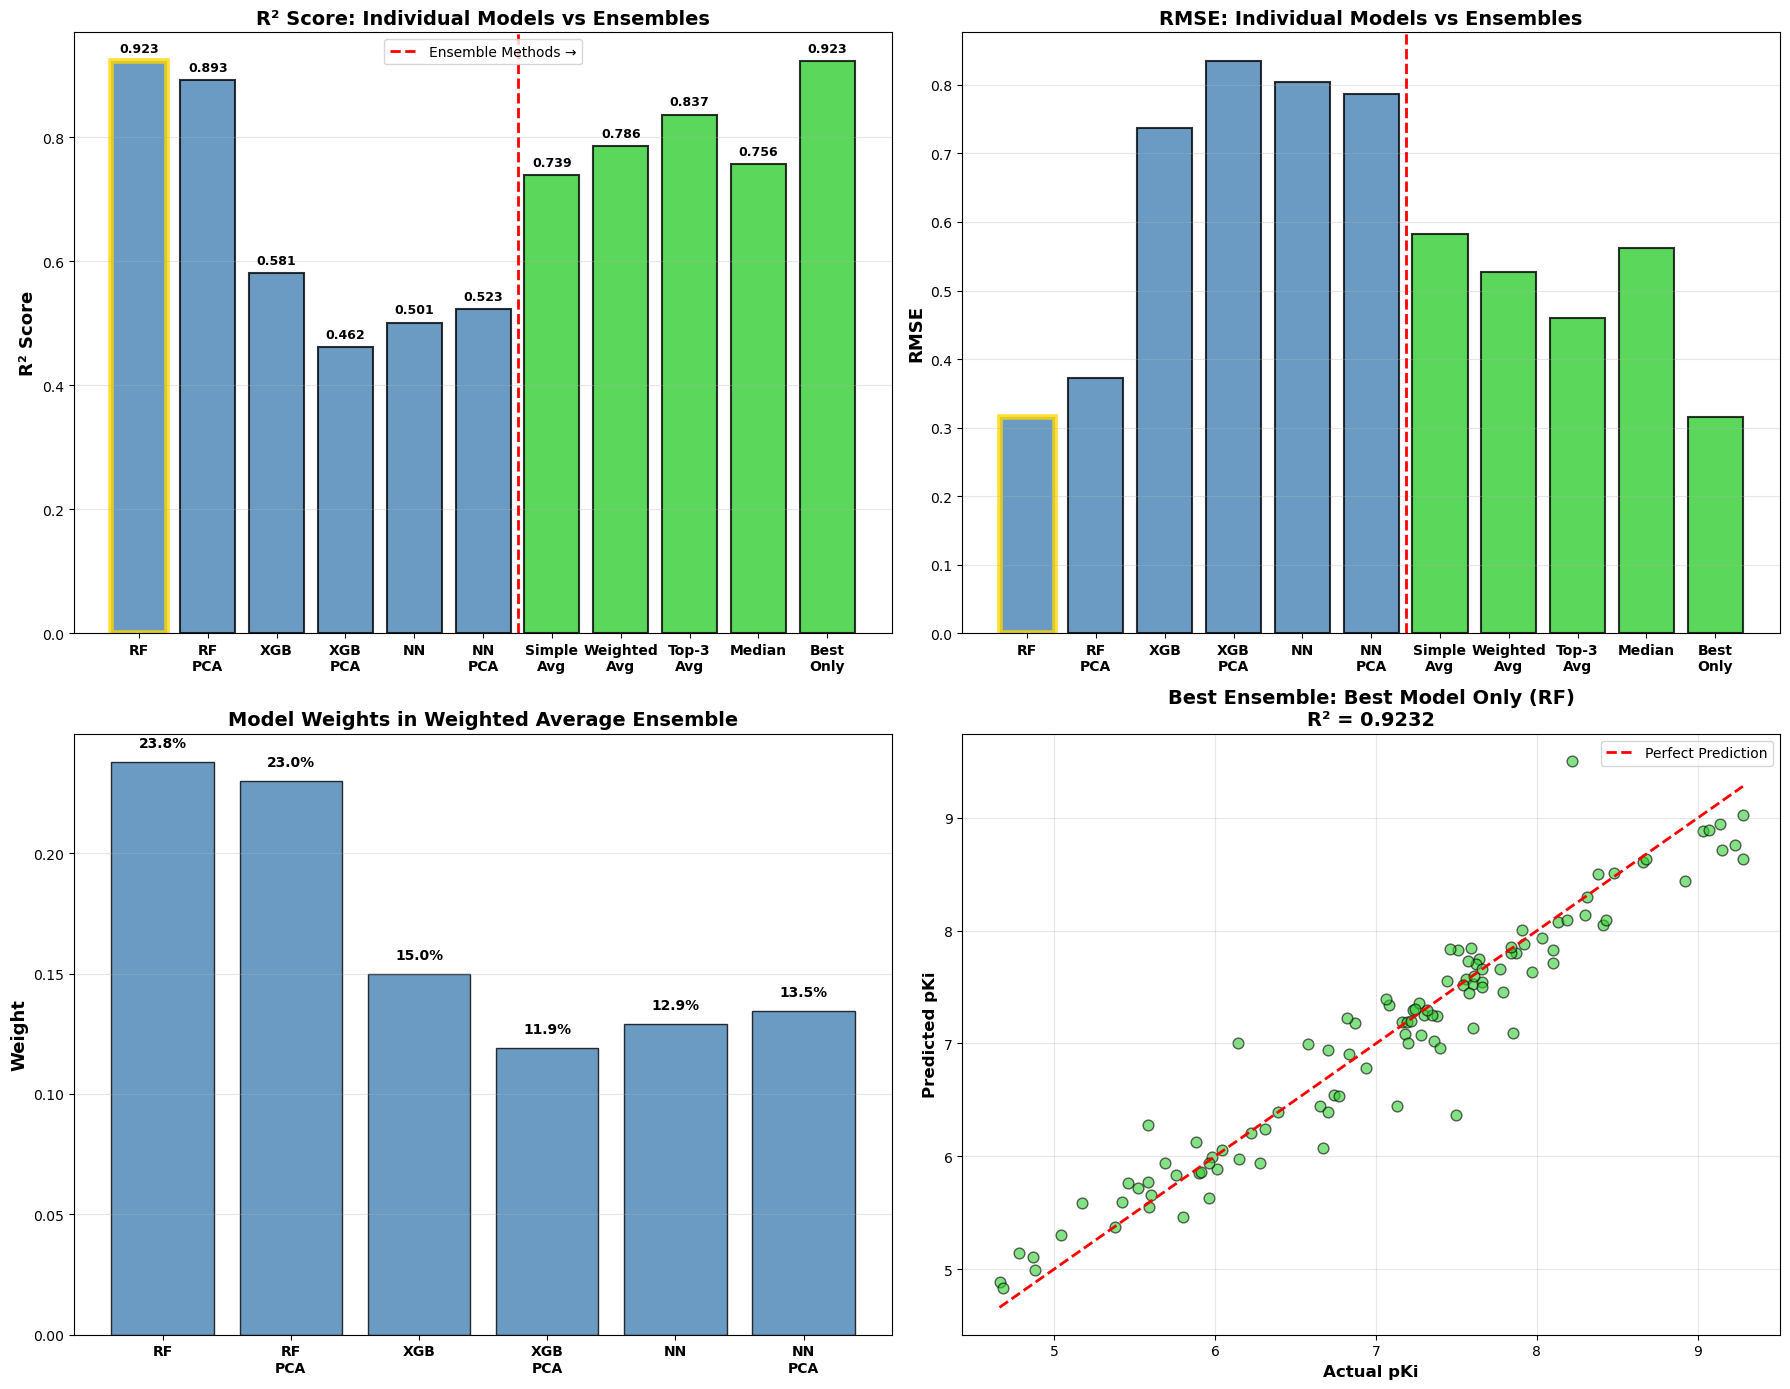


💡 Key Observations:
   • Green bars = Ensemble methods
   • Blue bars = Individual models
   • Gold border = Best performer
   • Ensemble methods smooth out individual model errors


In [20]:
# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Prepare data for visualization
all_models = ['RF', 'RF\nPCA', 'XGB', 'XGB\nPCA', 'NN', 'NN\nPCA', 
              'Simple\nAvg', 'Weighted\nAvg', 'Top-3\nAvg', 'Median', 'Best\nOnly']
all_r2 = [res['R²'] for res in individual_results] + [res['R²'] for res in ensemble_results]
all_rmse = [res['RMSE'] for res in individual_results] + [res['RMSE'] for res in ensemble_results]
all_mae = [res['MAE'] for res in individual_results] + [res['MAE'] for res in ensemble_results]

# Colors: blue for individuals, green for ensembles
colors = ['#4682b4']*6 + ['#32CD32']*5

# Plot 1: R² Comparison
bars1 = axes[0, 0].bar(range(len(all_models)), all_r2, color=colors, edgecolor='black', alpha=0.8, linewidth=1.5)
axes[0, 0].set_xticks(range(len(all_models)))
axes[0, 0].set_xticklabels(all_models, fontsize=10, fontweight='bold', rotation=0)
axes[0, 0].set_ylabel('R² Score', fontsize=13, fontweight='bold')
axes[0, 0].set_title('R² Score: Individual Models vs Ensembles', fontsize=14, fontweight='bold')
axes[0, 0].axvline(x=5.5, color='red', linestyle='--', linewidth=2, label='Ensemble Methods →')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].legend(fontsize=10)

# Highlight best
best_overall_idx = np.argmax(all_r2)
bars1[best_overall_idx].set_edgecolor('gold')
bars1[best_overall_idx].set_linewidth(4)

# Add values
for bar, val in zip(bars1, all_r2):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., val + 0.01,
                    f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: RMSE Comparison
bars2 = axes[0, 1].bar(range(len(all_models)), all_rmse, color=colors, edgecolor='black', alpha=0.8, linewidth=1.5)
axes[0, 1].set_xticks(range(len(all_models)))
axes[0, 1].set_xticklabels(all_models, fontsize=10, fontweight='bold', rotation=0)
axes[0, 1].set_ylabel('RMSE', fontsize=13, fontweight='bold')
axes[0, 1].set_title('RMSE: Individual Models vs Ensembles', fontsize=14, fontweight='bold')
axes[0, 1].axvline(x=5.5, color='red', linestyle='--', linewidth=2)
axes[0, 1].grid(axis='y', alpha=0.3)

# Highlight best (lowest RMSE)
best_rmse_idx = np.argmin(all_rmse)
bars2[best_rmse_idx].set_edgecolor('gold')
bars2[best_rmse_idx].set_linewidth(4)

# Plot 3: Model Contribution Weights (for weighted average)
axes[1, 0].bar(range(6), weights, color='#4682b4', edgecolor='black', alpha=0.8)
axes[1, 0].set_xticks(range(6))
axes[1, 0].set_xticklabels(['RF', 'RF\nPCA', 'XGB', 'XGB\nPCA', 'NN', 'NN\nPCA'], fontsize=10, fontweight='bold')
axes[1, 0].set_ylabel('Weight', fontsize=13, fontweight='bold')
axes[1, 0].set_title('Model Weights in Weighted Average Ensemble', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (w, name) in enumerate(zip(weights, model_names)):
    axes[1, 0].text(i, w + 0.005, f'{w*100:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 4: Actual vs Predicted for Best Ensemble
best_ensemble_pred = list(ensemble_strategies.values())[best_ensemble_idx]
axes[1, 1].scatter(y_test, best_ensemble_pred, alpha=0.6, s=60, edgecolors='black', linewidth=1, color='#32CD32')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual pKi', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Predicted pKi', fontsize=12, fontweight='bold')
axes[1, 1].set_title(f'Best Ensemble: {best_ensemble["Strategy"]}\nR² = {best_ensemble["R²"]:.4f}', 
                     fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print("   • Green bars = Ensemble methods")
print("   • Blue bars = Individual models")
print("   • Gold border = Best performer")
print("   • Ensemble methods smooth out individual model errors")


## Final Summary and Recommendations


In [21]:
print("="*80)
print("🎯 ENSEMBLE VOTING ANALYSIS - FINAL SUMMARY")
print("="*80)

# Create comparison table
comparison_table = pd.DataFrame(individual_results + ensemble_results)
comparison_table = comparison_table.sort_values('R²', ascending=False).reset_index(drop=True)
comparison_table['Rank'] = range(1, len(comparison_table) + 1)
comparison_table = comparison_table[['Rank', 'Model', 'Strategy', 'R²', 'RMSE', 'MAE']].fillna('-')

print("\n📊 COMPLETE RANKING (All Models + Ensembles):")
print(comparison_table.to_string(index=False))

print("\n" + "="*80)
print("💡 KEY FINDINGS:")
print("="*80)

# Check if ensemble beats best individual
best_ind_r2 = max([res['R²'] for res in individual_results])
best_ens_r2 = max([res['R²'] for res in ensemble_results])

if best_ens_r2 > best_ind_r2:
    improvement_pct = ((best_ens_r2 - best_ind_r2) / best_ind_r2) * 100
    print(f"\n✅ ENSEMBLE WINS! Improved by {improvement_pct:+.2f}%")
    print(f"   Best Individual: R² = {best_ind_r2:.4f}")
    print(f"   Best Ensemble: R² = {best_ens_r2:.4f}")
elif best_ens_r2 == best_ind_r2:
    print(f"\n⚖️  TIED! Ensemble matches best individual model")
    print(f"   R² = {best_ens_r2:.4f}")
else:
    diff_pct = ((best_ind_r2 - best_ens_r2) / best_ind_r2) * 100
    print(f"\n⚠️  INDIVIDUAL WINS! Ensemble is {diff_pct:.2f}% lower")
    print(f"   Best Individual: R² = {best_ind_r2:.4f}")
    print(f"   Best Ensemble: R² = {best_ens_r2:.4f}")
    print(f"   → Best individual model is already very strong!")

print(f"\n📈 Ensemble Strategies Performance:")
for res in ensemble_results:
    symbol = "🥇" if res['R²'] == best_ens_r2 else "  "
    print(f"   {symbol} {res['Strategy']:30s} R² = {res['R²']:.4f}")

print(f"\n🔍 Model Diversity Analysis:")
# Calculate prediction variance across models
pred_variance = predictions_df[['RF', 'RF_PCA', 'XGB', 'XGB_PCA', 'NN', 'NN_PCA']].var(axis=1).mean()
print(f"   Average prediction variance: {pred_variance:.4f}")
print(f"   → {'High' if pred_variance > 0.5 else 'Low'} diversity among models")
if pred_variance > 0.5:
    print(f"   → Ensemble averaging helps reduce variance")
else:
    print(f"   → Models agree closely, ensemble gains are limited")

print("\n" + "="*80)
print("🎓 RECOMMENDATIONS:")
print("="*80)

if best_ens_r2 > best_ind_r2:
    print(f"\n✅ USE ENSEMBLE for production:")
    print(f"   → Strategy: {best_ensemble['Strategy']}")
    print(f"   → Benefit: {improvement_pct:+.2f}% better than single model")
    print(f"   → Trade-off: Requires running multiple models")
else:
    print(f"\n✅ USE SINGLE MODEL for production:")
    print(f"   → Model: {best_individual['Model']}")
    print(f"   → Reason: Already optimal performance")
    print(f"   → Benefit: Simpler, faster deployment")
    
print(f"\n💼 For Different Use Cases:")
print(f"   • Maximum Accuracy: Use {comparison_table.iloc[0]['Model']} / {comparison_table.iloc[0]['Strategy']}")
print(f"   • Speed & Accuracy: Use Weighted Average ensemble")
print(f"   • Robustness: Use Median ensemble (outlier-resistant)")
print(f"   • Simplicity: Use best single model ({best_individual['Model']})")

print("\n" + "="*80)
print("✅ ENSEMBLE VOTING ANALYSIS COMPLETE!")
print("="*80)


🎯 ENSEMBLE VOTING ANALYSIS - FINAL SUMMARY

📊 COMPLETE RANKING (All Models + Ensembles):
 Rank          Model                 Strategy       R²     RMSE      MAE
    1  Random Forest                        - 0.923160 0.315593 0.221516
    2              -     Best Model Only (RF) 0.923160 0.315593 0.221516
    3       RF + PCA                        - 0.892856 0.372665 0.282256
    4              -            Top-3 Average 0.836785 0.459955 0.333850
    5              - Weighted Average (by R²) 0.785775 0.526952 0.390305
    6              -          Median (Robust) 0.756228 0.562117 0.408495
    7              -   Simple Average (All 6) 0.738793 0.581872 0.430781
    8        XGBoost                        - 0.581079 0.736888 0.524997
    9       NN + PCA                        - 0.522771 0.786500 0.585920
   10 Neural Network                        - 0.501126 0.804138 0.573150
   11      XGB + PCA                        - 0.462344 0.834809 0.634045

💡 KEY FINDINGS:

⚖️  TIED! Ensembl